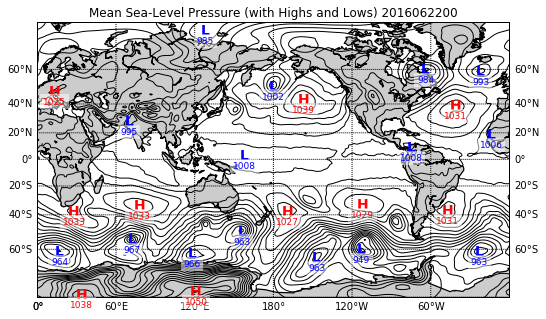

In [4]:
"""
plot H's and L's on a sea-level pressure map
(uses scipy.ndimage.filters and netcdf4-python)
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.basemap import Basemap, addcyclic
from scipy.ndimage.filters import minimum_filter, maximum_filter
from netCDF4 import Dataset

def extrema(mat,mode='wrap',window=10):
    """find the indices of local extrema (min and max)
    in the input array."""
    mn = minimum_filter(mat, size=window, mode=mode)
    mx = maximum_filter(mat, size=window, mode=mode)
    # (mat == mx) true if pixel is equal to the local max
    # (mat == mn) true if pixel is equal to the local in
    # Return the indices of the maxima, minima
    return np.nonzero(mat == mn), np.nonzero(mat == mx)

# plot 00 UTC today.
date = datetime.now().strftime('%Y%m%d')+'00'

# open OpenDAP dataset.
#data=Dataset("http://nomads.ncep.noaa.gov:9090/dods/gfs/gfs/%s/gfs_%sz_anl" %\
#        (date[0:8],date[8:10]))
data=Dataset("http://nomads.ncep.noaa.gov:9090/dods/gfs_1p00/gfs%s/gfs_1p00_%sz"%\
        (date[0:8],date[8:10]))


# read lats,lons.
lats = data.variables['lat'][:]
lons1 = data.variables['lon'][:]
nlats = len(lats)
nlons = len(lons1)
# read prmsl, convert to hPa (mb).
prmsl = 0.01*data.variables['prmslmsl'][0]
# the window parameter controls the number of highs and lows detected.
# (higher value, fewer highs and lows)
local_min, local_max = extrema(prmsl, mode='wrap', window=50)
# create Basemap instance.
m =\
Basemap(llcrnrlon=0,llcrnrlat=-80,urcrnrlon=360,urcrnrlat=80,projection='mill')
# add wrap-around point in longitude.
prmsl, lons = addcyclic(prmsl, lons1)
# contour levels
clevs = np.arange(900,1100.,5.)
# find x,y of map projection grid.
lons, lats = np.meshgrid(lons, lats)
x, y = m(lons, lats)
# create figure.
fig=plt.figure(figsize=(8,4.5))
ax = fig.add_axes([0.05,0.05,0.9,0.85])
cs = m.contour(x,y,prmsl,clevs,colors='k',linewidths=1.)
m.drawcoastlines(linewidth=1.25)
m.fillcontinents(color='0.8')
m.drawparallels(np.arange(-80,81,20),labels=[1,1,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
xlows = x[local_min]; xhighs = x[local_max]
ylows = y[local_min]; yhighs = y[local_max]
lowvals = prmsl[local_min]; highvals = prmsl[local_max]
# plot lows as blue L's, with min pressure value underneath.
xyplotted = []
# don't plot if there is already a L or H within dmin meters.
yoffset = 0.022*(m.ymax-m.ymin)
dmin = yoffset
for x,y,p in zip(xlows, ylows, lowvals):
    if x < m.xmax and x > m.xmin and y < m.ymax and y > m.ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'L',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='b')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='b',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))
# plot highs as red H's, with max pressure value underneath.
xyplotted = []
for x,y,p in zip(xhighs, yhighs, highvals):
    if x < m.xmax and x > m.xmin and y < m.ymax and y > m.ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'H',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='r')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='r',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))
plt.title('Mean Sea-Level Pressure (with Highs and Lows) %s' % date)
plt.show()
